 # Identifying Common Expressions Used In Queer Songs

Parts of the code is based on the exercises from the course Natural Language Engineering 2 and changed accordingly.

Other sources: https://github.com/q-downgrade/queer-subreddit-nlp/blob/master/code/1-modeling-and-analyzing-data.ipynb,
https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html,
https://huggingface.co/docs/transformers/model_doc/roberta

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.feature_extraction._stop_words import ENGLISH_STOP_WORDS
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import torch
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from transformers import RobertaTokenizer, RobertaForSequenceClassification, AdamW
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
from nltk.stem import WordNetLemmatizer
from sklearn.metrics import accuracy_score


import warnings
warnings.filterwarnings('ignore')

## Loading Data and Analysis

Parts of the Code taken from Q Leedham. queer-subreddit-nlp (2020). 
Source: https://github.com/q-downgrade/queer-subreddit-nlp/blob/master/code/1-modeling-and-analyzing-data.ipynb .
Code was adjusted 

In [2]:
# Loads the datasets from the created CSV files (CreatingDatasets.ipynb)
lesbian_df = pd.read_csv("lesbian_songs.csv")
gay_df = pd.read_csv("gay_songs.csv")
bi_df = pd.read_csv("bi_songs.csv")
transgender_df = pd.read_csv("transgender_songs.csv")
straight_df = pd.read_csv("straight_songs.csv")

In [3]:
# List of the data frames
dataframes = [lesbian_df, gay_df, bi_df, transgender_df, straight_df]

# Data frame names
dataframe_names = ["lesbian_df", "gay_df", "bi_df", "transgender_df", "straight_df"]

In [4]:
lesbian_df.head()

,id,artist,title,lyrics,tag,year,views,features,language_cld3,language_ft,language
0,1688280,Gaye Adegbalola,Nothings Changed,Sit-ins and picket lines for civil rights\nDog...,pop,1999,142.0,{},en,en,en
1,3056891,Alex the Astronaut,Already Home,"[Verse 1]\nBus was late\nI don't care, I guess...",pop,2016,2941.0,{},en,en,en
2,3056952,Alex the Astronaut,Rockstar City,[Verse 1]\nWild smiles from the streets\nI thi...,pop,2017,1795.0,{},en,en,en
3,3056962,Alex the Astronaut,I Believe in Music,[Verse 1]\nFor my seventh birthday\nI was give...,pop,2017,487.0,{},en,en,en
4,3218483,Alex the Astronaut,Not Worth Hiding,[Verse 1]\nI learnt to drive to school when I ...,pop,2017,10047.0,{},en,en,en


In [5]:
# List of the columns to delete in the data frames
columns_to_delete = ['id', 'views', 'features', 'language_cld3', 'language_ft']

# Deletes the columns and rows where 'language' is not 'en' in all data frames
for df, name in zip(dataframes, dataframe_names):
    df.drop(columns=columns_to_delete, inplace=True)
    original_rows = len(df)
    df.drop(df[df['language'] != 'en'].index, inplace=True)
    removed_rows = original_rows - len(df)
    print(f'Number of Missing Values in {name}:')
    print(df.isnull().sum())
    print(f'Number of Rows in {name}: {len(df)}')


Number of Missing Values in lesbian_df:
artist      0
title       0
lyrics      0
tag         0
year        0
language    0
dtype: int64
Number of Rows in lesbian_df: 6982
Number of Missing Values in gay_df:
artist      0
title       1
lyrics      0
tag         0
year        0
language    0
dtype: int64
Number of Rows in gay_df: 24918
Number of Missing Values in bi_df:
artist      0
title       0
lyrics      0
tag         0
year        0
language    0
dtype: int64
Number of Rows in bi_df: 22365
Number of Missing Values in transgender_df:
artist      0
title       0
lyrics      0
tag         0
year        0
language    0
dtype: int64
Number of Rows in transgender_df: 6056
Number of Missing Values in straight_df:
artist      0
title       0
lyrics      0
tag         0
year        0
language    0
dtype: int64
Number of Rows in straight_df: 55303


In [6]:
bi_df.head()

,artist,title,lyrics,tag,year,language
0,Brett Anderson,Crash About To Happen,Your face is armed with a sabotage of lipstick...,pop,2011,en
1,Brett Anderson,Hymn,"Shining through the plate glass, hyacinths and...",pop,2009,en
2,Brett Anderson,With You Within You,When the Libra moon is high\nAnd your ashes li...,pop,2015,en
3,Brett Anderson,Infinite Kiss,And when your clothes are on the ground\nAnd y...,pop,2007,en
4,Brett Anderson,Song for My Father,Now my body is sand\nAnd the wind blows throug...,pop,2007,en


In [7]:
# Combines the LGBTQIA+ data frames in one
queer_df = pd.concat([lesbian_df, gay_df, bi_df, transgender_df], ignore_index=True)

dataframes.append(queer_df)
dataframe_names.append("queer_df")

In [8]:
pronouns = ['she', 'her', 'hers', 'he', 'him', 'his', 'they', 'them', 'theirs']
# Removes the pronouns from the ENGLISH_STOP_WORDS list
stop_words = set(word for word in ENGLISH_STOP_WORDS if word not in pronouns)

In [10]:
NUM_TOP_WORDS = 20

Source used: https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

Top Words in lesbian_df:
    Word  Frequency
11  love      12008
2    don      11102
10  like      10440
7   know      10289
16  they       9297
4     he       9249
6   just       8993
5    his       7327
3    got       6489
18    ve       6276
17  time       6142
15   she       5632
19  want       5287
8    let       5163
13   man       5068
14   say       5005
1   come       4925
9   life       4623
12  make       4436
0   baby       4276


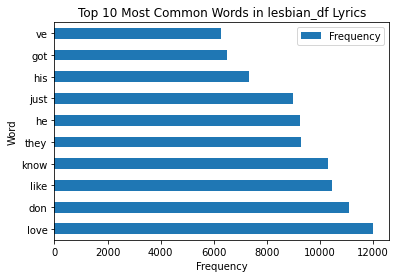

Top Words in gay_df:
     Word  Frequency
3     don      42949
11   love      42702
10   like      39612
8    know      38602
7    just      36386
15   they      27878
4     got      26323
14    she      23119
5      he      22074
16   time      21626
17     ve      20556
9     let      19130
18   want      17395
0    baby      16230
13    say      16172
2    come      16154
19    way      15804
12   make      15562
1   cause      14301
6     her      14123


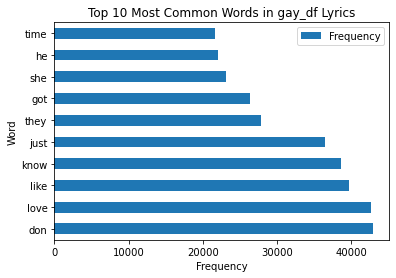

Top Words in bi_df:
     Word  Frequency
3     don      42416
9    like      39643
7    know      38170
6    just      33683
10   love      33545
14   they      26987
4     got      25544
5      he      21558
13    she      21179
15   time      20236
18   want      18340
8     let      18271
16     ve      18036
11   make      16529
0    baby      15971
1   cause      15406
17  wanna      15126
12    say      15093
19    way      14310
2    come      14044


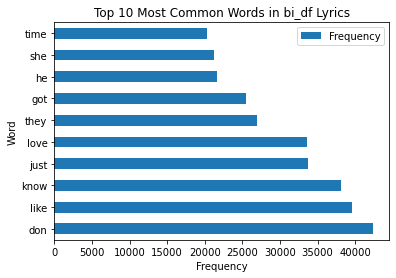

Top Words in transgender_df:
     Word  Frequency
2     don      11676
6    know       9899
8    like       9539
5    just       8436
9    love       7807
14   they       5745
4     got       5309
15   time       5154
18   want       4716
16     ve       4537
7     let       4470
10   make       3887
1   cause       3834
17  wanna       3794
13    she       3791
3    feel       3758
12    say       3561
11   need       3405
19    way       3348
0    baby       3254


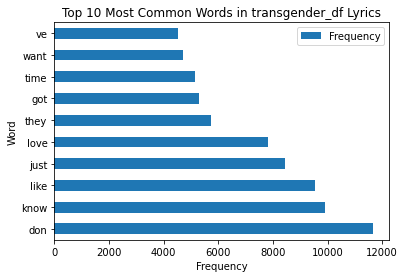

Top Words in straight_df:
    Word  Frequency
3    don     101638
11  love      85549
10  like      84954
8   know      83640
7   just      77929
4    got      73239
15  they      65942
14   she      64264
5     he      57172
1   baby      56242
16  time      47032
2   come      43520
9    let      43189
17    ve      39000
6    her      38741
18  want      37383
13   say      36222
12  make      34346
0    ain      34341
19   way      33923


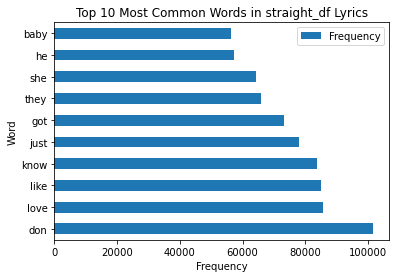

Top Words in queer_df:
     Word  Frequency
3     don     108143
9    like      99234
7    know      96960
10   love      96062
6    just      87498
14   they      69907
4     got      63665
5      he      56081
13    she      53721
15   time      53158
16     ve      49405
8     let      47034
18   want      45738
11   make      40414
12    say      39831
0    baby      39731
2    come      38229
19    way      37564
1   cause      37260
17  wanna      35700


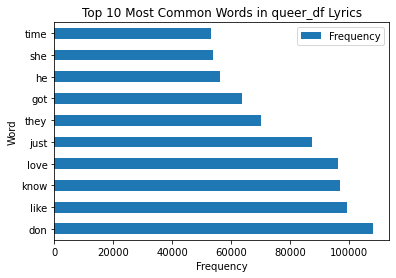

In [11]:
# Words to be removed from the dataset
words_to_remove = ['oh', 'ah', 'yeah', 'yea', 'ya', 'la', 'uh', 'um', 'hey', 'woo', 'whoa', 'na', 'ooh', 'aah', 'll']

# Creates a regular expression to remove these words
word_pattern = r'\b(?:' + '|'.join(re.escape(word) for word in words_to_remove) + r')\b'

# Creates a CountVectorizer using the stop_words variable
count_vectorizer = CountVectorizer(stop_words=stop_words, max_features=NUM_TOP_WORDS)

for df, name in zip(dataframes, dataframe_names):
    lyrics_data = df['lyrics']

    # Text preprocessing steps
    lyrics_data = lyrics_data.str.lower()
    lyrics_data = lyrics_data.apply(lambda x: re.sub(r'\[.*?\]', '', x))
    lyrics_data = lyrics_data.apply(lambda x: re.sub(word_pattern, '', x))

    # Transformes the lyrics data
    word_counts = count_vectorizer.fit_transform(lyrics_data)

    # Extracts the words and their frequencies
    words = count_vectorizer.get_feature_names()

    # Creates a DataFrame with the top words and their frequencies
    word_frequencies = word_counts.sum(axis=0)
    top_words_df = pd.DataFrame({'Word': words, 'Frequency': word_frequencies.tolist()[0]})

    # Sorts the DataFrame by frequency in descending ordere
    top_words_df = top_words_df.sort_values(by='Frequency', ascending=False)

    # Output of the most frequently used words
    print(f'Top Words in {name}:')
    print(top_words_df)

    # Visualizes the top words in a horizontal bar chart
    top_words_df.head(10).plot(kind='barh', x='Word', y='Frequency')
    plt.xlabel('Frequency')
    plt.ylabel('Word')
    plt.title(f'Top 10 Most Common Words in {name} Lyrics')
    plt.show()


Top Bigram Phrases in lesbian_df:
        Phrase  Frequency
8     don know       1587
44      ve got       1538
36       oh oh       1319
33   love love       1088
27       la la        969
12   don wanna        805
13    don want        754
48   yeah yeah        619
19   just like        595
10    don need        595
37     ooh ooh        529
15   feel like        529
34       na na        510
23   know know        501
42    they say        461
6        da da        420
7     don care        352
5    come come        337
31   love hate        326
38     run run        325
47   want want        312
9      don let        307
20  just wanna        298
39    she said        293
21   just want        291
41    they don        281
11   don think        275
45     ve seen        275
0        ah ah        275
17     he said        272
25   know love        270
1    baby baby        265
22    know don        261
29  little bit        258
28   like like        258
24     know ll        255
46  

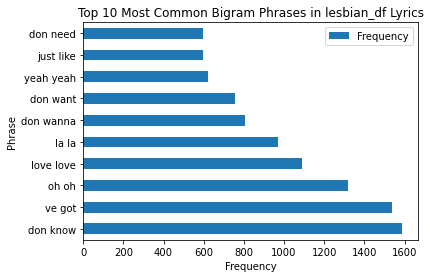

Top Bigram Phrases in gay_df:
        Phrase  Frequency
9     don know       6103
36       oh oh       6001
44      ve got       4454
32   love love       4099
49   yeah yeah       3653
13   don wanna       2790
14    don want       2615
37     ooh ooh       2297
15   feel like       1982
23   know know       1963
19   just like       1858
11    don need       1730
7     don care       1547
26       la la       1481
42    they say       1440
20  just wanna       1431
10     don let       1369
18     hey hey       1189
25   know love       1126
43   time time       1105
22    know don       1081
40    they don       1049
31   love like       1019
5    come come       1009
24     know ll       1004
47   want want        970
1      ain got        958
21   just want        950
2    baby baby        949
28  little bit        922
45     ve seen        921
34       na na        920
48     won let        915
8      don don        905
27     let let        902
3     baby don        880
30    lo

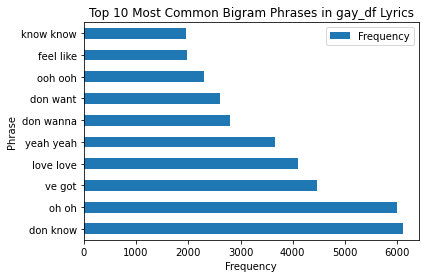

Top Bigram Phrases in bi_df:
        Phrase  Frequency
36       oh oh      10847
8     don know       5944
49   yeah yeah       3943
45      ve got       3702
32   love love       3635
37     ooh ooh       3489
13   don wanna       3156
0        ah ah       2783
14    don want       2511
28       la la       2163
18   feel like       2096
25   know know       2047
11    don need       1974
21   just like       1643
22  just wanna       1628
5        da da       1491
6     don care       1489
20     hey hey       1469
43    they say       1398
34       na na       1371
48   want want       1232
16       eh eh       1157
30  little bit       1143
24    know don       1123
15     doo doo       1098
1      ain got       1082
23   just want       1027
2    baby baby       1012
44   time time        996
41    they don        964
12   don think        942
4    come come        924
9      don let        921
3     baby don        920
19  feels like        879
26     know ll        870
17    far

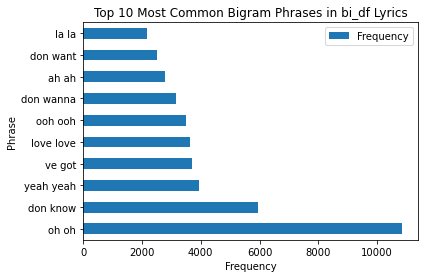

Top Bigram Phrases in transgender_df:
         Phrase  Frequency
38        oh oh       1725
5      don know       1699
45       ve got        923
10    don wanna        901
11     don want        798
49    yeah yeah        777
26        la la        673
8      don need        620
33    love love        606
14    feel like        595
39      ooh ooh        571
22    know know        517
2         da da        475
3      don care        432
17    just like        414
18   just wanna        409
0         ah ah        360
6       don let        355
20     know don        347
36        na na        334
23      know ll        321
12      doo doo        313
43     they say        301
40  right right        287
34    make feel        286
19    just want        283
1    close eyes        281
15   feels like        266
28    like like        264
32     love don        259
9     don think        257
24      know ve        256
48    want want        252
44    time time        247
29   little bit  

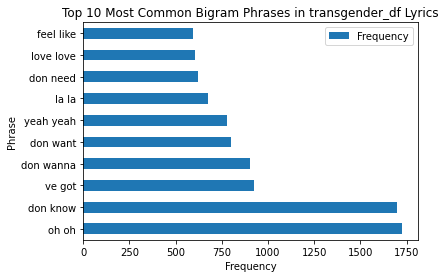

Top Bigram Phrases in straight_df:
        Phrase  Frequency
8     don know      13144
49   yeah yeah      12668
38       oh oh      10542
47      ve got      10477
32   love love       7489
14    don want       5893
27       la la       5529
21   just like       5238
39     ooh ooh       5029
13   don wanna       4983
19     hey hey       4599
2    baby baby       4551
24   know know       3784
16   feel like       3752
6     don care       3688
4    come come       3550
10    don need       3472
0        ah ah       3249
3     baby don       3184
17       ha ha       3111
9      don let       3090
45    they say       3072
37     oh baby       3022
1      ain got       3019
15     doo doo       2820
42    she said       2801
46   time time       2622
26   know love       2597
43    they don       2558
41     she got       2532
29  little bit       2457
5        da da       2399
18     he said       2327
22  just wanna       2253
11    don stop       2208
40   rock roll       2188
7  

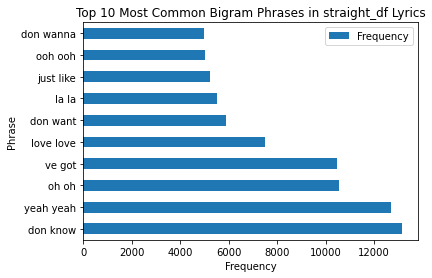

Top Bigram Phrases in queer_df:
        Phrase  Frequency
39       oh oh      19892
9     don know      15333
46      ve got      10617
36   love love       9428
49   yeah yeah       8992
14   don wanna       7652
40     ooh ooh       6886
15    don want       6678
29       la la       5286
18   feel like       5202
26   know know       5028
12    don need       4919
22   just like       4510
0        ah ah       4276
7     don care       3820
23  just wanna       3766
44    they say       3600
6        da da       3139
38       na na       3135
21     hey hey       3038
10     don let       2952
25    know don       2812
48   want want       2766
45   time time       2584
32  little bit       2557
24   just want       2551
42    they don       2511
27     know ll       2450
5    come come       2436
2    baby baby       2393
1      ain got       2359
13   don think       2330
28   know love       2299
3     baby don       2238
19  feels like       2230
47     ve seen       2191
16    

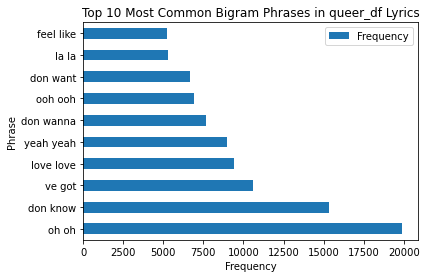

In [12]:
# Phrases to be removed from the dataset
phrases_to_remove = ['oh yeah', 'la la', 'uh huh', 'oh oh', 'da da', 'ah ah', 'yeah yeah', 'yea yea', 'ya ya', 'uh uh', 'um um', 'hey hey', 'woo woo', 'whoa whoa', 'na na', 'ooh ooh', 'aah aah', 'll ll']

phrase_pattern = re.compile(r'(?:\b(?:' + '|'.join(re.escape(phrase.strip()) for phrase in phrases_to_remove) + r')\b)+?', re.IGNORECASE)

# Creates a CountVectorizer using the stop_words variable and with 2 grams
count_vectorizer = CountVectorizer(stop_words=stop_words, ngram_range=(2, 2), max_features=50)

for df, name in zip(dataframes, dataframe_names):
    lyrics_data = df['lyrics']

    # Text preprocessing steps
    lyrics_data = lyrics_data.str.lower() 
    lyrics_data = lyrics_data.apply(lambda x: re.sub(r'\[.*?\]', '', x))
    lyrics_data = lyrics_data.apply(lambda x: re.sub(phrase_pattern, '', x))

    # Transforms the lyrics data with 2-grams (bigrams)
    phrase_counts = count_vectorizer.fit_transform(lyrics_data)

    # Extracts the bigrams and their frequencies
    phrases = count_vectorizer.get_feature_names()

    # Creates a DataFrame with the top bigrams and their frequencies
    phrase_frequencies = phrase_counts.sum(axis=0)
    top_phrases_df = pd.DataFrame({'Phrase': phrases, 'Frequency': phrase_frequencies.tolist()[0]})

    # Sorts the DataFrame by frequency in descending order
    top_phrases_df = top_phrases_df.sort_values(by='Frequency', ascending=False)

    # Output of the most frequently used bigramsn
    print(f'Top Bigram Phrases in {name}:')
    print(top_phrases_df)

    # Visualizes the top bigrams in a horizontal bar chart
    top_phrases_df.head(10).plot(kind='barh', x='Phrase', y='Frequency')
    plt.xlabel('Frequency')
    plt.ylabel('Phrase')
    plt.title(f'Top 10 Most Common Bigram Phrases in {name} Lyrics')
    plt.show()


## Processing Data

Parts of the Code taken from Q Leedham. queer-subreddit-nlp (2020). 
Source: https://github.com/q-downgrade/queer-subreddit-nlp/blob/master/code/1-modeling-and-analyzing-data.ipynb .
Code was adjusted 

In [13]:
label_names = ["lesbian", "gay", "bi", "transgender", "straight", "queer"]

# Creates an empty list to store the data frames
dfs_with_label = []

# Loop over the data frames and add the "label" column
for df, name in zip(dataframes, label_names):
    df['label'] = name
    dfs_with_label.append(df)

# Combines data frames
complete_df = pd.concat(dfs_with_label, ignore_index=True)

# Only select 1500 entries per label
samples_per_label = 1500
balanced_data = pd.DataFrame()

for label in label_names:
    label_data = complete_df[complete_df['label'] == label]
    if len(label_data) >= samples_per_label:
        balanced_data = pd.concat([balanced_data, label_data.sample(n=samples_per_label)])
    else:
        balanced_data = pd.concat([balanced_data, label_data])

In [17]:
complete_df.head(10000)

,artist,title,lyrics,tag,year,language,label
0,Gaye Adegbalola,Nothings Changed,Sit-ins and picket lines for civil rights\nDog...,pop,1999,en,lesbian
1,Alex the Astronaut,Already Home,"[Verse 1]\nBus was late\nI don't care, I guess...",pop,2016,en,lesbian
2,Alex the Astronaut,Rockstar City,[Verse 1]\nWild smiles from the streets\nI thi...,pop,2017,en,lesbian
3,Alex the Astronaut,I Believe in Music,[Verse 1]\nFor my seventh birthday\nI was give...,pop,2017,en,lesbian
4,Alex the Astronaut,Not Worth Hiding,[Verse 1]\nI learnt to drive to school when I ...,pop,2017,en,lesbian
...,...,...,...,...,...,...,...
9995,Declan Bennett,Blu Tack,"Face up, stare at the ceiling\nCold hard floor...",pop,2008,en,gay
9996,Declan Bennett,Zs and Q,I want to be ignorant\nI don’t want to care\nI...,pop,2008,en,gay
9997,Declan Bennett,Limelight,You are your time right now\nNo star burns bri...,pop,2008,en,gay
9998,Declan Bennett,Things Unseen,Maybe i’ll stay\nMaybe i’ll go\nMaybe i’ll wai...,pop,2008,en,gay


In [ ]:
X_data = balanced_data['lyrics']

Y_data = balanced_data['label']

# Splits data into training and test sets
X_train, X_test, Y_train, Y_test = train_test_split(X_data, Y_data, test_size=0.2, random_state=42)

In [ ]:
# Text cleanup function
def clean_text(text):
    text = re.sub(r'[^a-zA-Z\s]', '', text)  
    text = text.lower() 
    text = re.sub(r'\[.*?\]', '', text) 
    text = re.sub(word_pattern, '', text) 
    text = re.sub(r'\n', ' ', text)
    
    return text

# Apply text cleaning to data
X_train = X_train.apply(clean_text)
X_test = X_test.apply(clean_text)

## Modeling

### Base Model

In [ ]:
Y_test.value_counts(normalize = True)

straight       0.172222
queer          0.168889
transgender    0.167778
lesbian        0.166667
bi             0.166111
gay            0.158333
Name: label, dtype: float64

### RoBERTa-Modell

Source used: https://huggingface.co/docs/transformers/model_doc/roberta

In [ ]:
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")

# Tokenizes text data and creates tensors
train_encodings = tokenizer(list(X_train), truncation=True, padding=True, max_length=128, return_tensors='pt')
test_encodings = tokenizer(list(X_test), truncation=True, padding=True, max_length=128, return_tensors='pt')

label_encoder = LabelEncoder()
Y_train_encoded = label_encoder.fit_transform(Y_train)
Y_test_encoded = label_encoder.transform(Y_test)

# Creates Tensor Datasets and DataLoaders
train_dataset = TensorDataset(train_encodings['input_ids'], train_encodings['attention_mask'], torch.tensor(Y_train_encoded))
test_dataset = TensorDataset(test_encodings['input_ids'], test_encodings['attention_mask'], torch.tensor(Y_test_encoded))

batch_size = 16

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Loads the pre-trained RoBERTa model for classification
model = RobertaForSequenceClassification.from_pretrained("roberta-base", num_labels=len(label_names))

# Defines the optimizer
optimizer = AdamW(model.parameters(), lr=1e-5)

# Trains the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

epochs = 4 

for epoch in range(epochs):
    model.train()
    for batch in train_loader:
        input_ids, attention_mask, labels = batch
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()

    # Model evaluation and calculation of classification metrics
    model.eval()
    predictions = []
    true_labels = []

    for batch in test_loader:
        input_ids, attention_mask, labels = batch
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

        with torch.no_grad():
            outputs = model(input_ids, attention_mask=attention_mask)

        logits = outputs.logits
        predicted_labels = torch.argmax(logits, dim=1)
        predictions.extend(predicted_labels.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

    # Output of the classification metrics
    print(f'Epoch {epoch + 1}:')
    print(classification_report(true_labels, predictions))

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.weight', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1:
              precision    recall  f1-score   support

           0       0.25      0.01      0.02       299
           1       0.14      0.01      0.02       285
           2       0.25      0.21      0.23       300
           3       0.00      0.00      0.00       304
           4       0.28      0.53      0.37       310
           5       0.21      0.64      0.32       302

    accuracy                           0.24      1800
   macro avg       0.19      0.23      0.16      1800
weighted avg       0.19      0.24      0.16      1800

Epoch 2:
              precision    recall  f1-score   support

           0       0.26      0.16      0.20       299
           1       0.50      0.01      0.02       285
           2       0.21      0.54      0.31       300
           3       0.18      0.01      0.01       304
           4       0.42      0.21      0.28       310
           5       0.24      0.54      0.33       302

    accuracy                           0.25      1800
   ma